In [76]:
!pip install catboost


In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score,recall_score
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, GridSearchCV

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

%config InlineBackend.figure_format = 'retina'

# to display all columns and rows:
pd.set_option('display.max_columns', None); pd.set_option('display.max_rows', None);

In [78]:
from google.colab import files
uploaded = files.upload()

Saving churn.csv to churn (3).csv


In [79]:
import pandas as pd
df = pd.read_csv("churn.csv", index_col=0)


In [80]:
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1.1+ MB


In [82]:
df.describe([0.05,0.25,0.50,0.75,0.90,0.95,0.99])

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
5%,1.557882e+07,489.000000,25.000000,1.000000,0.000000,1.000000,0.00000,0.000000,9851.818500,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
90%,1.579083e+07,778.000000,53.000000,9.000000,149244.792000,2.000000,1.00000,1.000000,179674.704000,1.000000
95%,1.580303e+07,812.000000,60.000000,9.000000,162711.669000,2.000000,1.00000,1.000000,190155.375500,1.000000


In [83]:
categorical_variables = [col for col in df.columns if col in "O"
                        or df[col].nunique() <=11
                        and col not in "Exited"]

categorical_variables

['Geography',
 'Gender',
 'Tenure',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember']

In [84]:
numeric_variables = [col for col in df.columns if df[col].dtype != "object"
                        and df[col].nunique() >11
                        and col not in "CustomerId"]
numeric_variables

['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

In [85]:
df["Exited"].value_counts()

,count
Exited,
0,7963
1,2037


In [86]:
churn = df.loc[df["Exited"]==1]

In [87]:
not_churn = df.loc[df["Exited"]==0]

***Categorical Variables***

In [88]:
not_churn["Tenure"].value_counts().sort_values()

,count
Tenure,
0,318
10,389
6,771
9,771
4,786
3,796
1,803
5,803
8,828


In [89]:
churn["Tenure"].value_counts().sort_values()

,count
Tenure,
0,95
10,101
7,177
6,196
8,197
2,201
4,203
5,209
3,213


In [90]:
not_churn["NumOfProducts"].value_counts().sort_values()

,count
NumOfProducts,
3,46
1,3675
2,4242


In [91]:
churn["NumOfProducts"].value_counts().sort_values()

,count
NumOfProducts,
4,60
3,220
2,348
1,1409


In [92]:
not_churn["HasCrCard"].value_counts()


,count
HasCrCard,
1,5631
0,2332


In [93]:
not_churn["IsActiveMember"].value_counts()

,count
IsActiveMember,
1,4416
0,3547


In [94]:
churn["IsActiveMember"].value_counts()

,count
IsActiveMember,
0,1302
1,735


In [95]:
not_churn.Geography.value_counts().sort_values()

,count
Geography,
Germany,1695
Spain,2064
France,4204


In [96]:
churn.Geography.value_counts().sort_values()

,count
Geography,
Spain,413
France,810
Germany,814


In [97]:
not_churn.Gender.value_counts()

,count
Gender,
Male,4559
Female,3404


In [98]:
churn.Gender.value_counts()

,count
Gender,
Female,1139
Male,898


In [99]:
not_churn["CreditScore"].describe([0.05,0.25,0.50,0.75,0.90,0.95,0.99])

,CreditScore
count,7963.000000
mean,651.853196
std,95.653837
min,405.000000
5%,492.000000
25%,585.000000
50%,653.000000
75%,718.000000
90%,778.000000
95%,812.000000


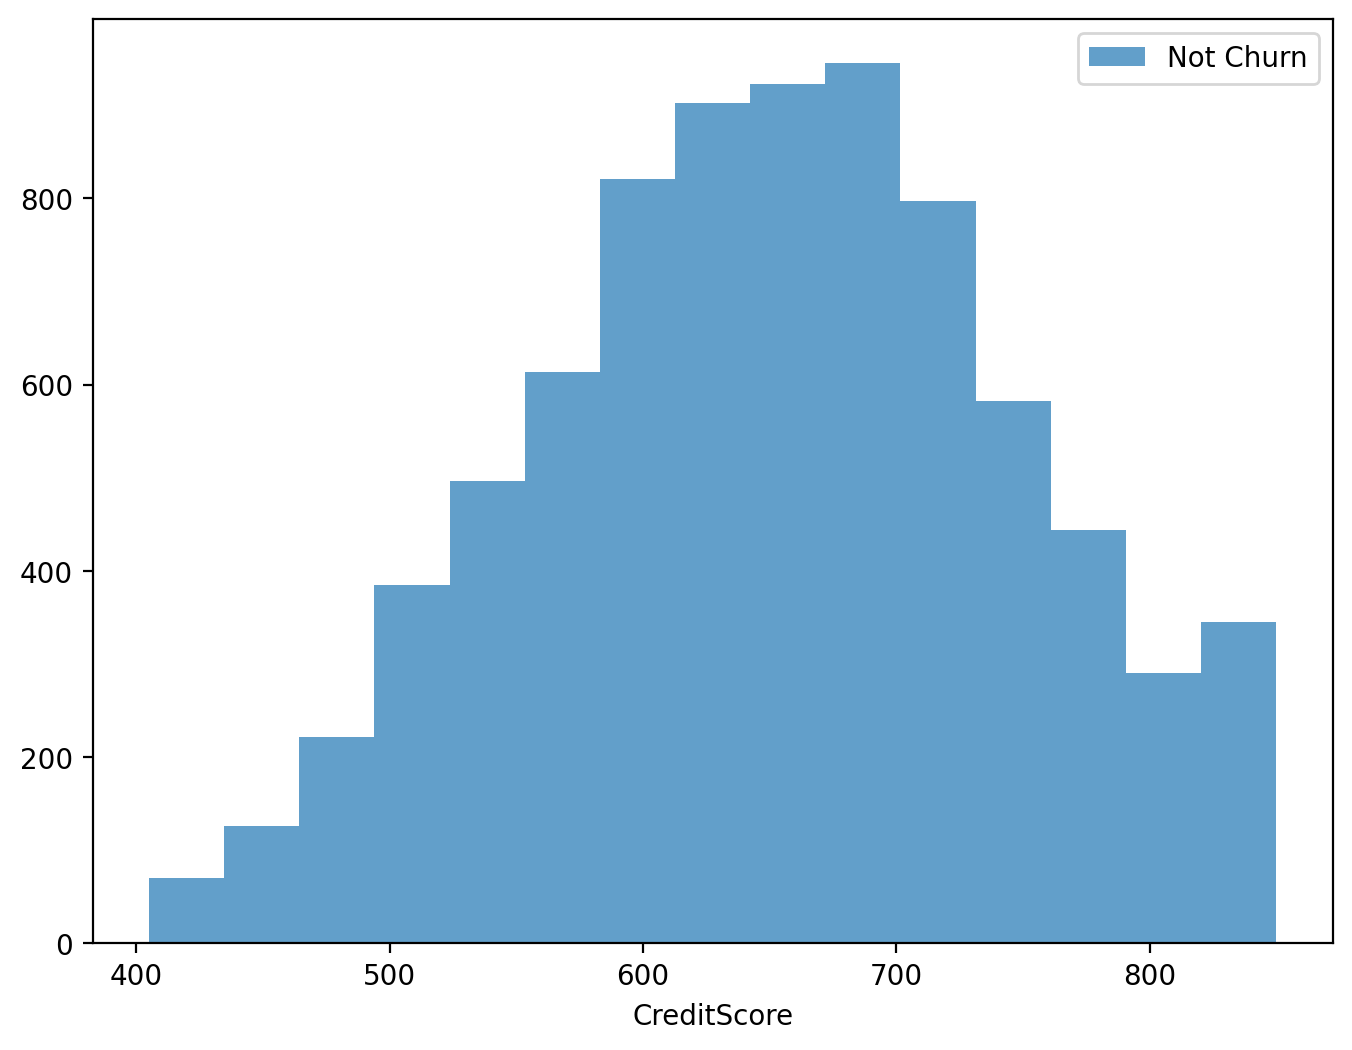

In [100]:
pyplot.figure(figsize=(8,6))
pyplot.xlabel('CreditScore')
pyplot.hist(not_churn["CreditScore"],bins=15, alpha=0.7, label='Not Churn')
pyplot.legend(loc='upper right')
pyplot.show()

In [101]:
churn["CreditScore"].describe([0.05,0.25,0.50,0.75,0.90,0.95,0.99])


,CreditScore
count,2037.000000
mean,645.351497
std,100.321503
min,350.000000
5%,479.000000
25%,578.000000
50%,646.000000
75%,716.000000
90%,776.400000
95%,812.200000


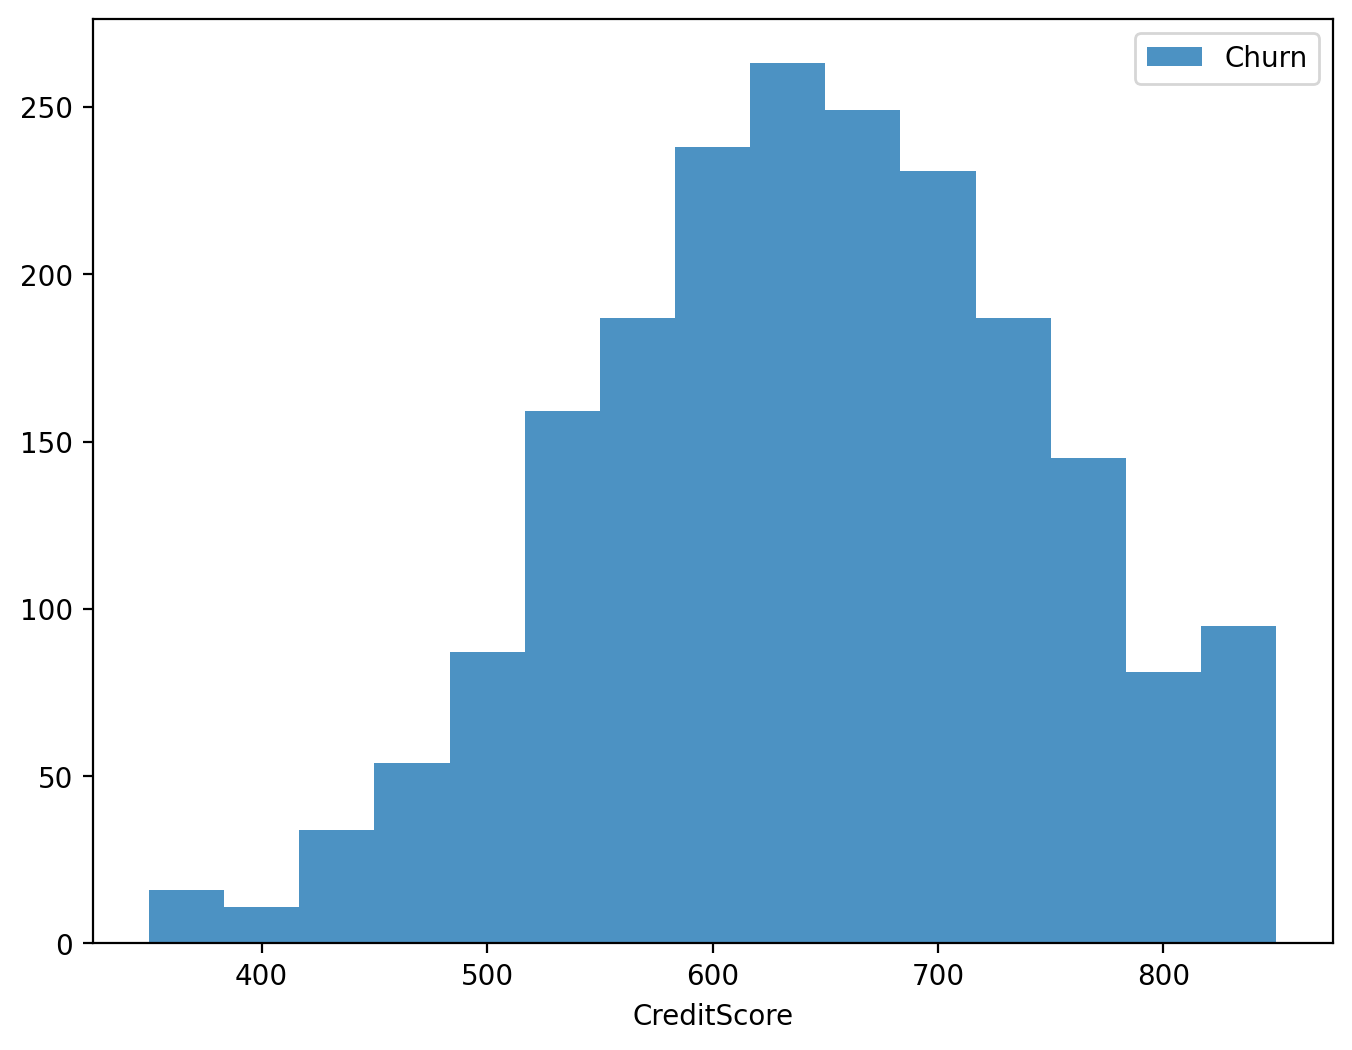

In [102]:
pyplot.figure(figsize=(8,6))
pyplot.xlabel('CreditScore')
pyplot.hist(churn["CreditScore"],bins=15, alpha=0.8, label='Churn')
pyplot.legend(loc='upper right')
pyplot.show()

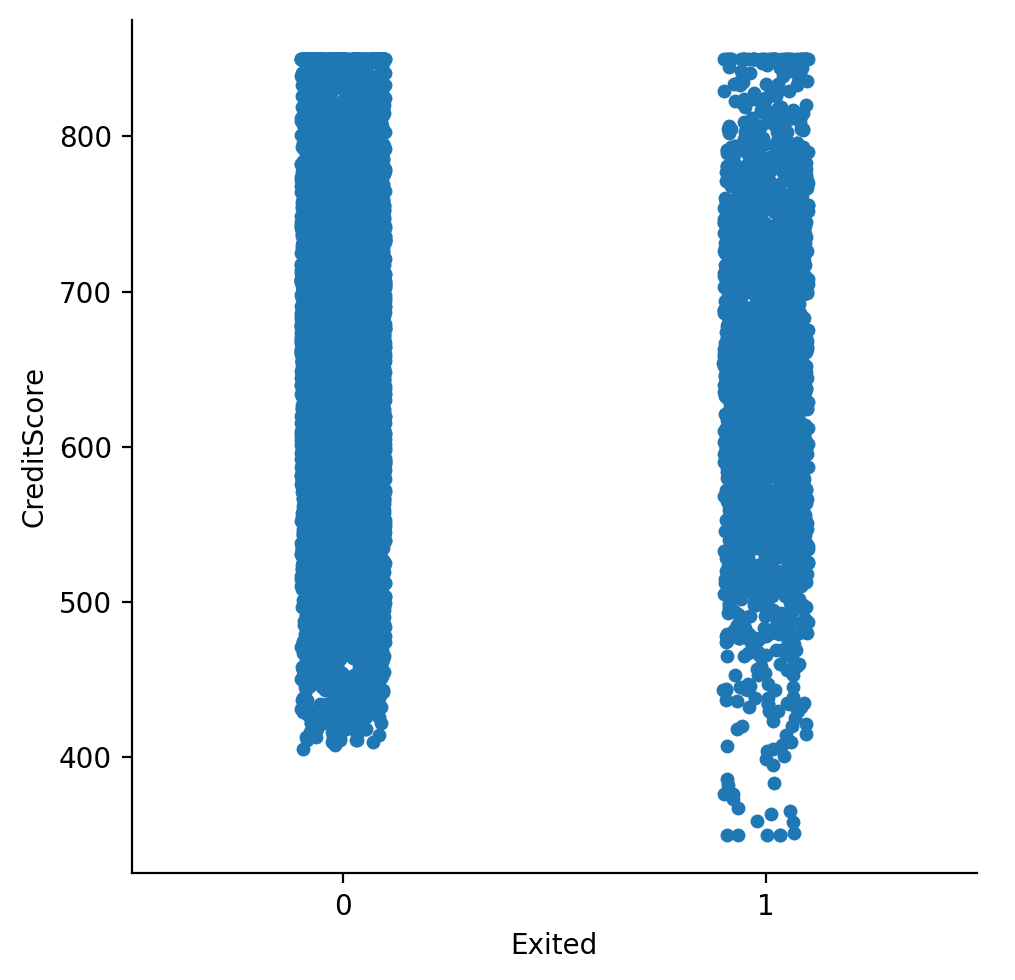

In [103]:
sns.catplot(x="Exited", y="CreditScore", data=df)

In [104]:
not_churn["Age"].describe([0.05,0.25,0.50,0.75,0.90,0.95,0.99])

,Age
count,7963.000000
mean,37.408389
std,10.125363
min,18.000000
5%,24.000000
25%,31.000000
50%,36.000000
75%,41.000000
90%,49.000000
95%,59.000000


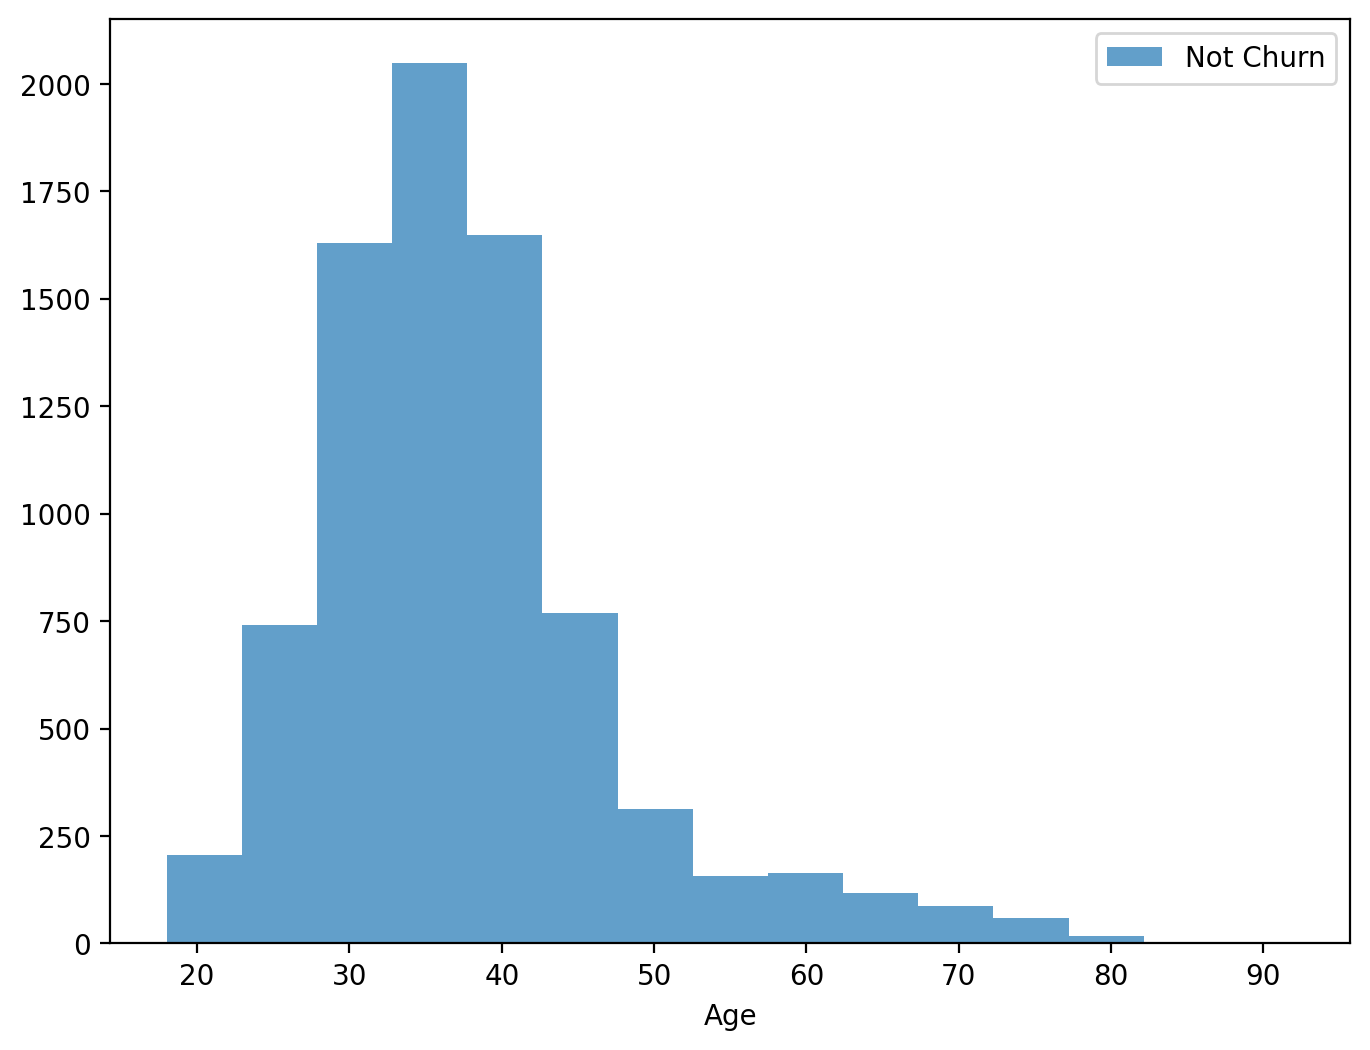

In [105]:
pyplot.figure(figsize=(8,6))
pyplot.xlabel('Age')
pyplot.hist(not_churn["Age"],bins=15, alpha=0.7, label='Not Churn')
pyplot.legend(loc='upper right')
pyplot.show()

In [106]:
churn["Age"].describe([0.05,0.25,0.50,0.75,0.90,0.95,0.99])

,Age
count,2037.000000
mean,44.837997
std,9.761562
min,18.000000
5%,29.000000
25%,38.000000
50%,45.000000
75%,51.000000
90%,58.000000
95%,61.000000


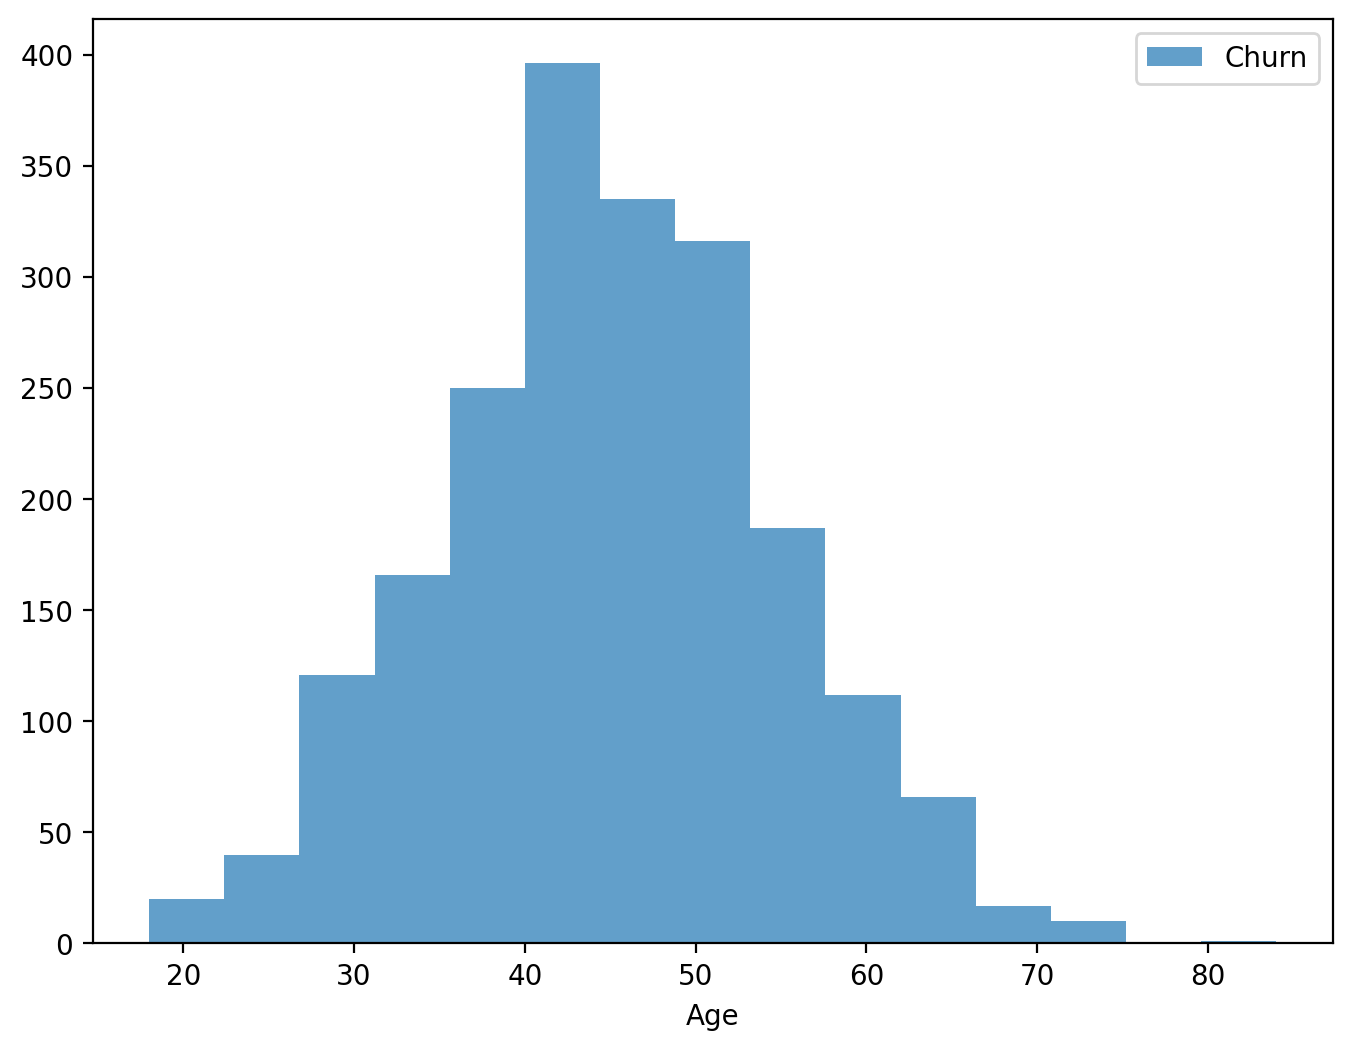

In [107]:
pyplot.figure(figsize=(8,6))
pyplot.xlabel('Age')
pyplot.hist(churn["Age"],bins=15, alpha=0.7, label='Churn')
pyplot.legend(loc='upper right')
pyplot.show()

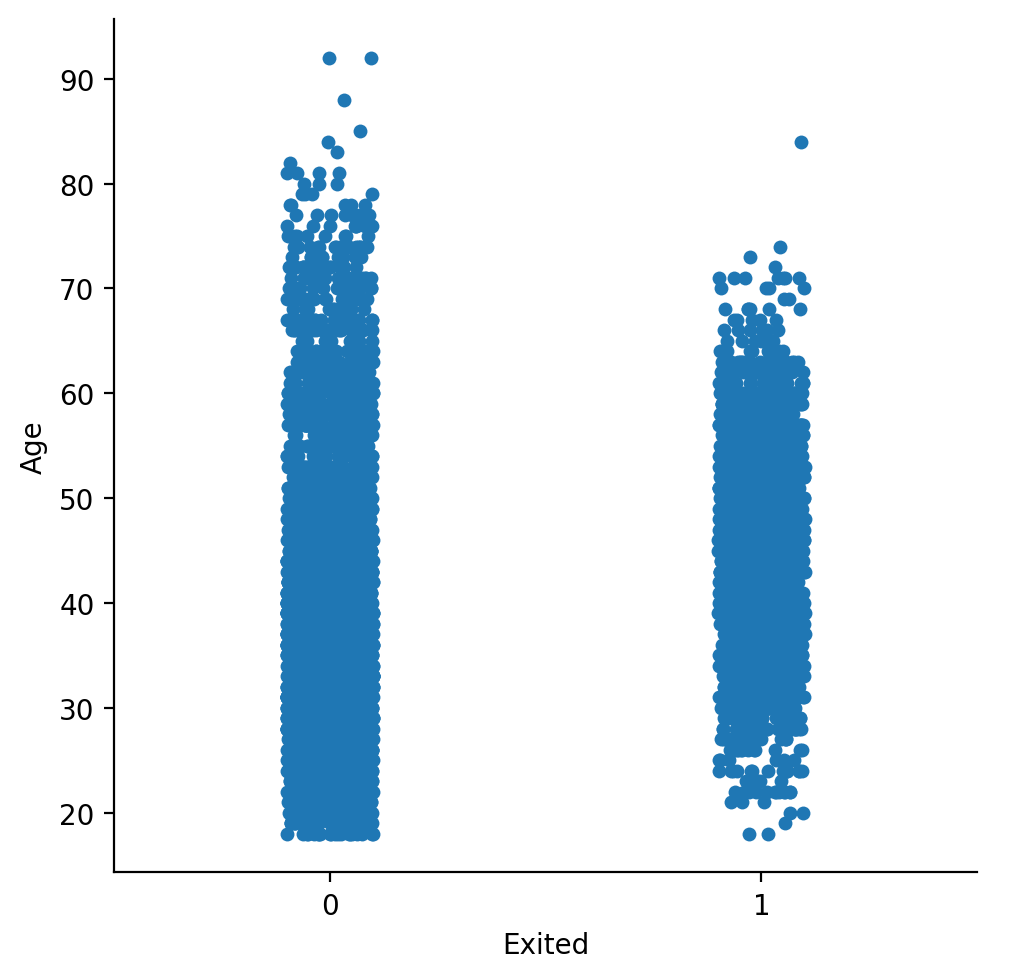

In [108]:
sns.catplot(x="Exited", y="Age", data = df)

In [109]:
not_churn["Balance"].describe([0.05,0.25,0.50,0.75,0.90,0.95,0.99])

,Balance
count,7963.000000
mean,72745.296779
std,62848.040701
min,0.000000
5%,0.000000
25%,0.000000
50%,92072.680000
75%,126410.280000
90%,148730.298000
95%,161592.595000


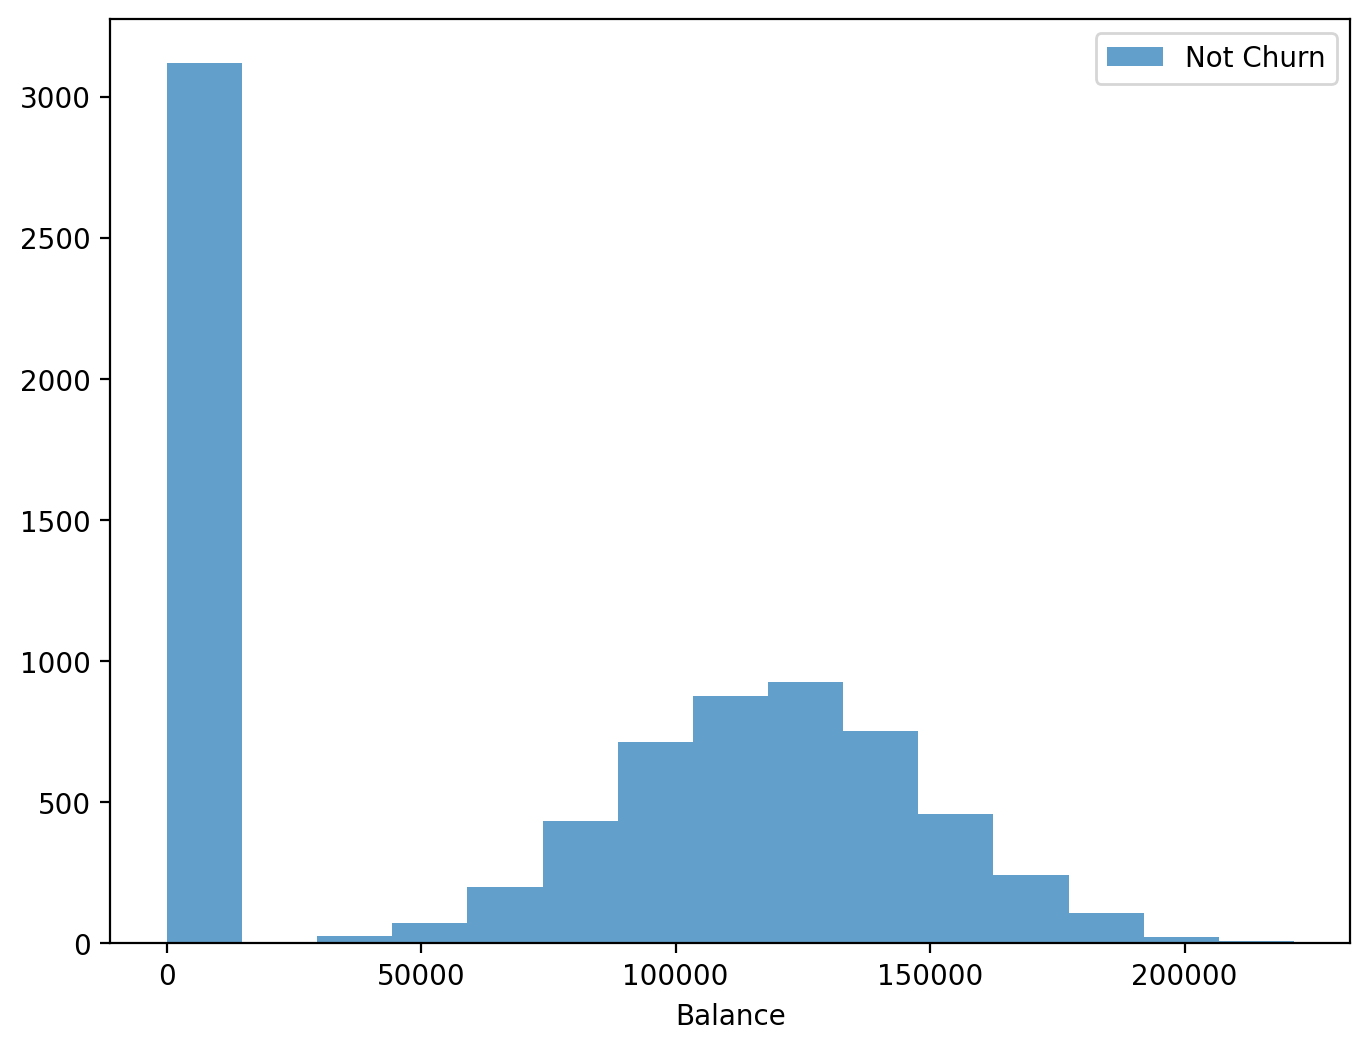

In [110]:
pyplot.figure(figsize=(8,6))
pyplot.xlabel('Balance')
pyplot.hist(not_churn["Balance"],bins=15, alpha=0.7, label='Not Churn')
pyplot.legend(loc='upper right')
pyplot.show()

In [111]:
churn["Balance"].describe([0.05,0.25,0.50,0.75,0.90,0.95,0.99])

,Balance
count,2037.000000
mean,91108.539337
std,58360.794816
min,0.000000
5%,0.000000
25%,38340.020000
50%,109349.290000
75%,131433.330000
90%,152080.618000
95%,167698.240000


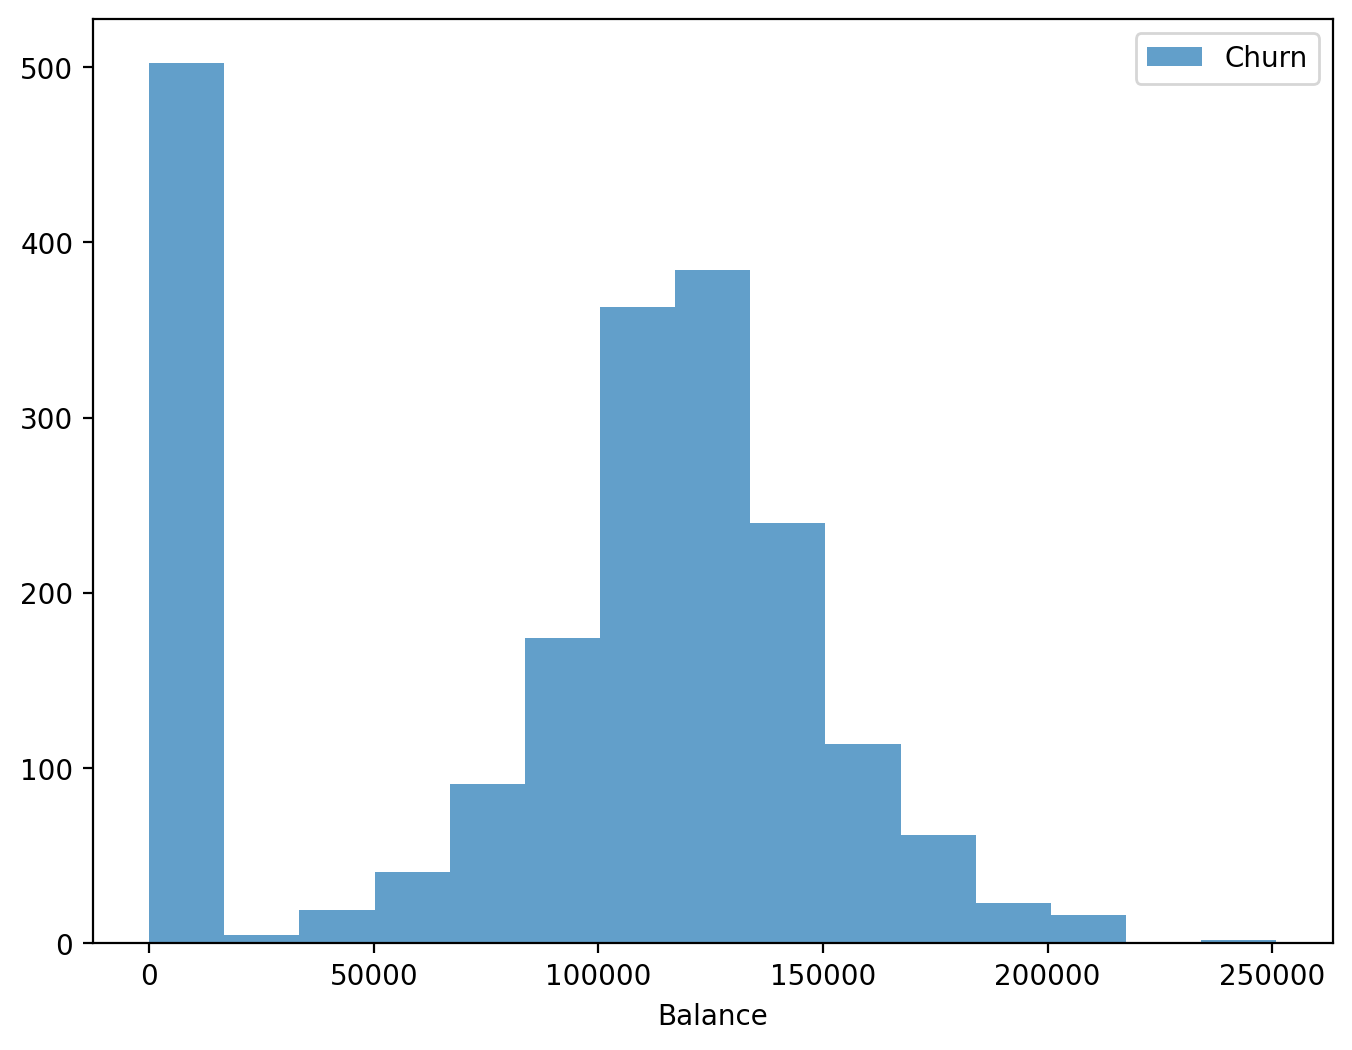

In [112]:
pyplot.figure(figsize=(8,6))
pyplot.xlabel('Balance')
pyplot.hist(churn["Balance"],bins=15, alpha=0.7, label='Churn')
pyplot.legend(loc='upper right')
pyplot.show()

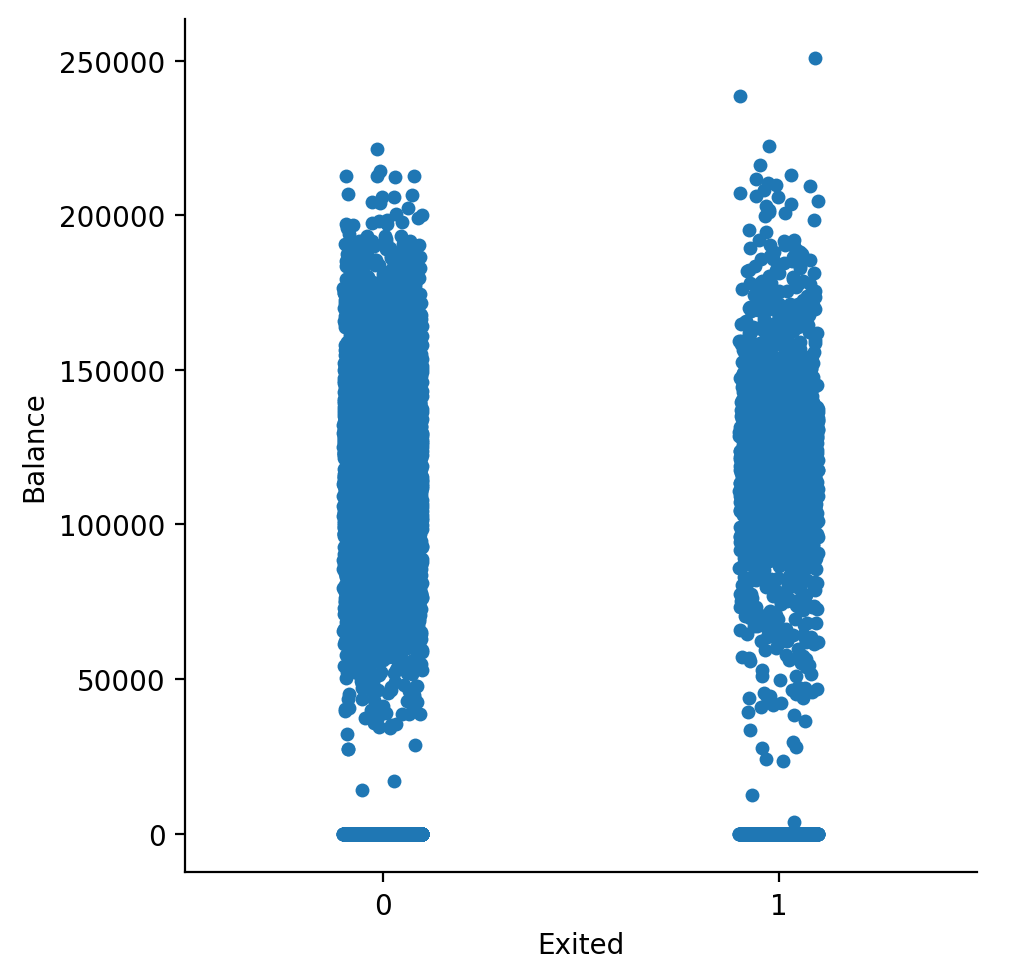

In [113]:
sns.catplot(x="Exited", y="Balance", data = df)

In [114]:
not_churn["EstimatedSalary"].describe([0.05,0.25,0.50,0.75,0.90,0.95,0.99])

,EstimatedSalary
count,7963.000000
mean,99738.391772
std,57405.586966
min,90.070000
5%,9773.542000
25%,50783.490000
50%,99645.040000
75%,148609.955000
90%,179453.212000
95%,190107.557000


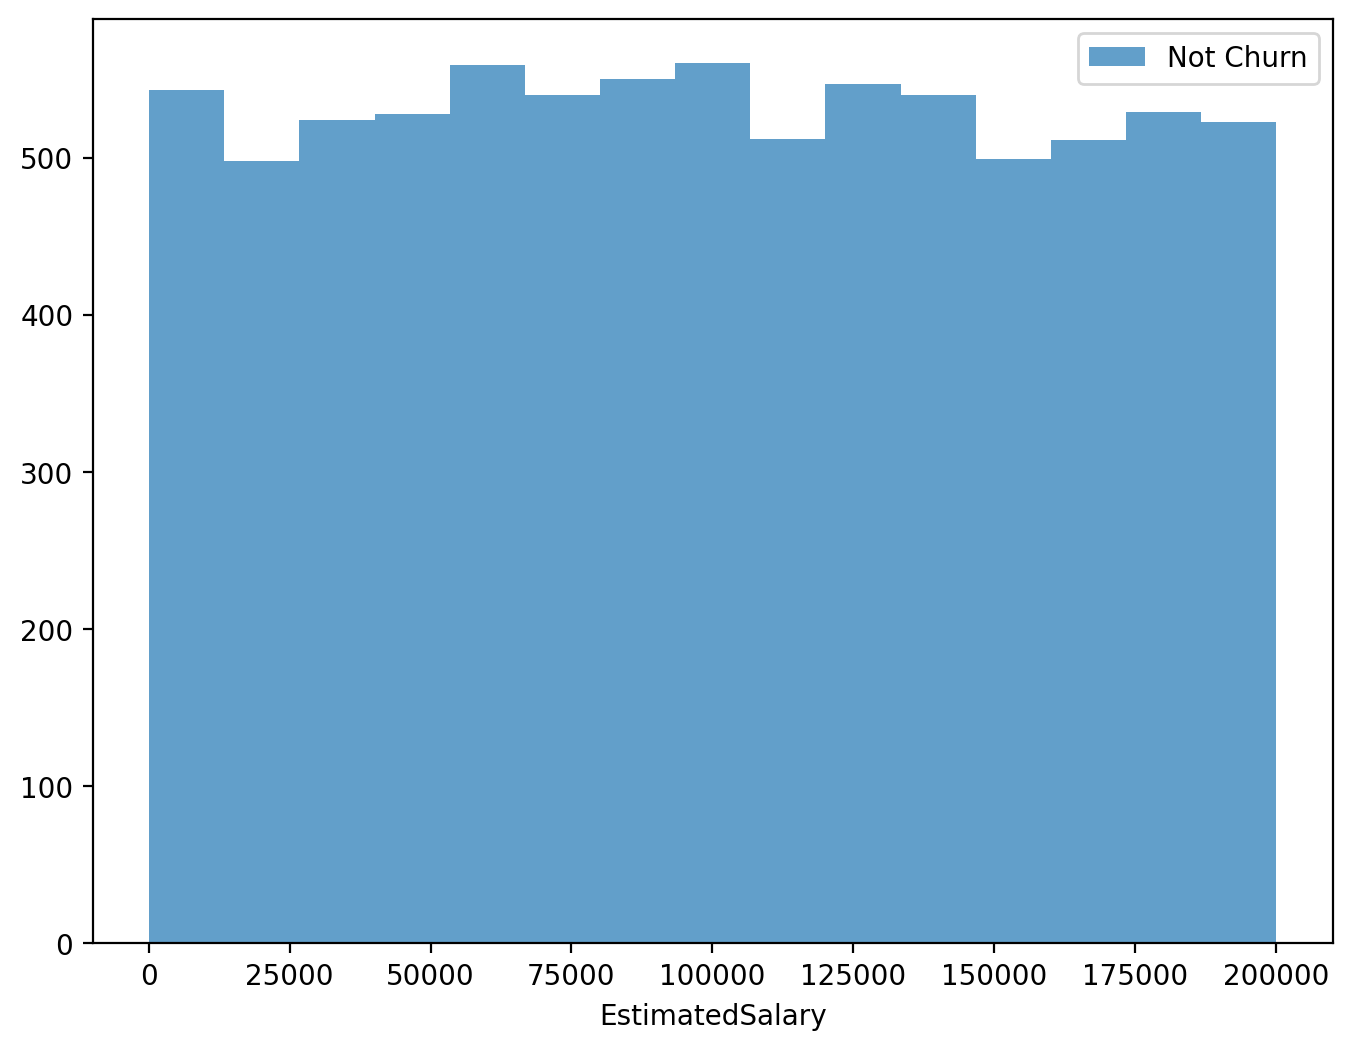

In [115]:
pyplot.figure(figsize=(8,6))
pyplot.xlabel('EstimatedSalary')
pyplot.hist(not_churn["EstimatedSalary"],bins=15, alpha=0.7, label='Not Churn')
pyplot.legend(loc='upper right')
pyplot.show()

In [116]:
churn["EstimatedSalary"].describe([0.05,0.25,0.50,0.75,0.90,0.95,0.99])

,EstimatedSalary
count,2037.000000
mean,101465.677531
std,57912.418071
min,11.580000
5%,10030.760000
25%,51907.720000
50%,102460.840000
75%,152422.910000
90%,180169.390000
95%,190328.982000


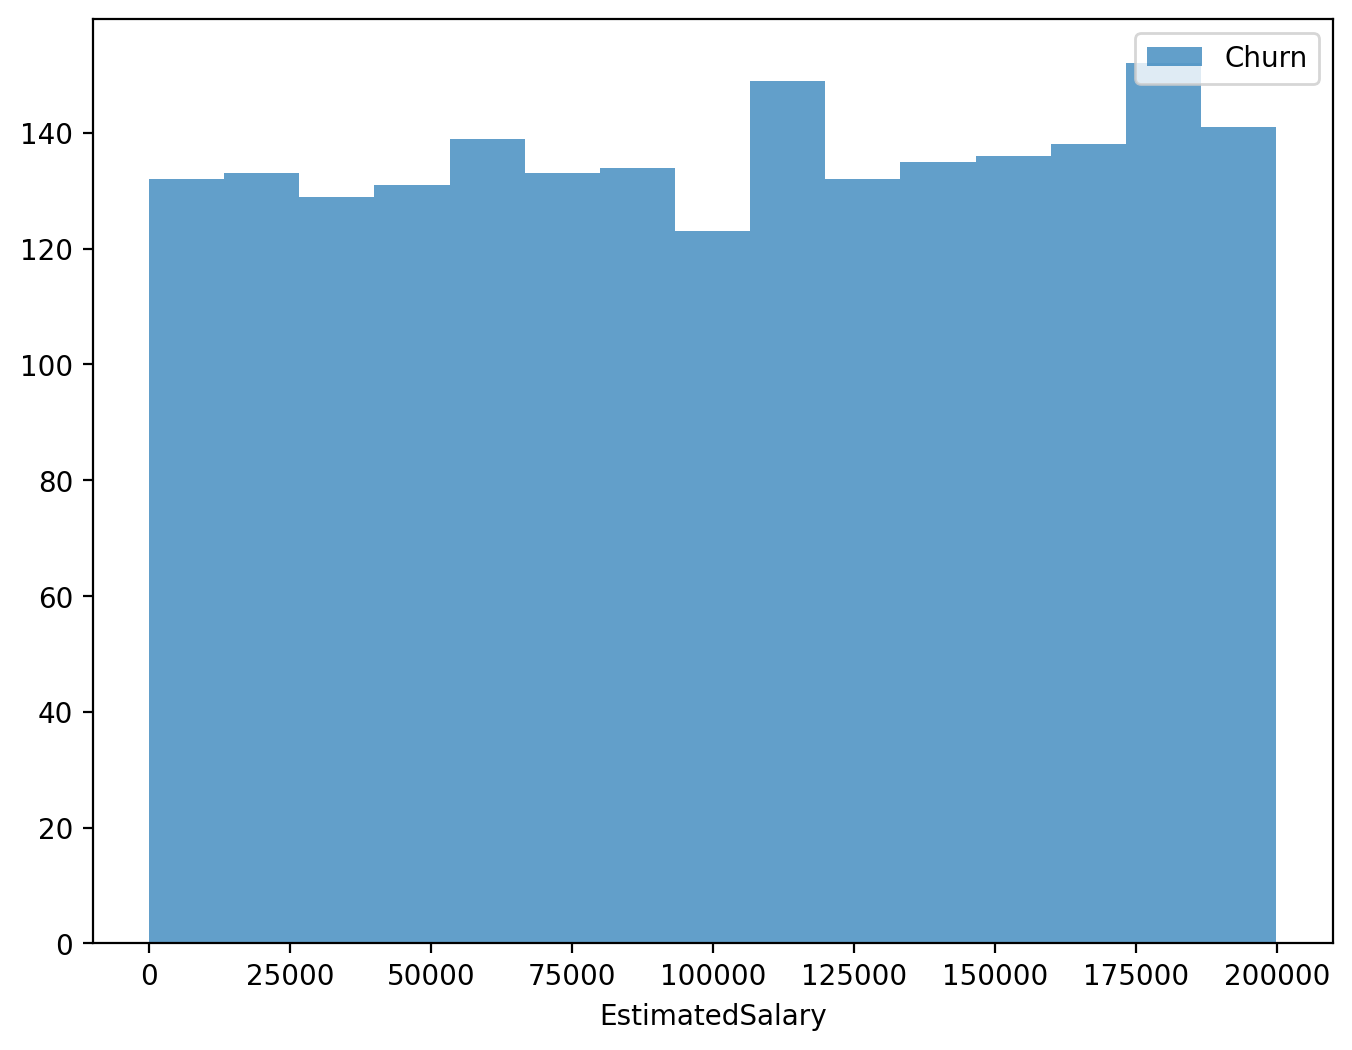

In [117]:
pyplot.figure(figsize=(8,6))
pyplot.xlabel('EstimatedSalary')
pyplot.hist(churn["EstimatedSalary"],bins=15, alpha=0.7, label='Churn')
pyplot.legend(loc='upper right')
pyplot.show()

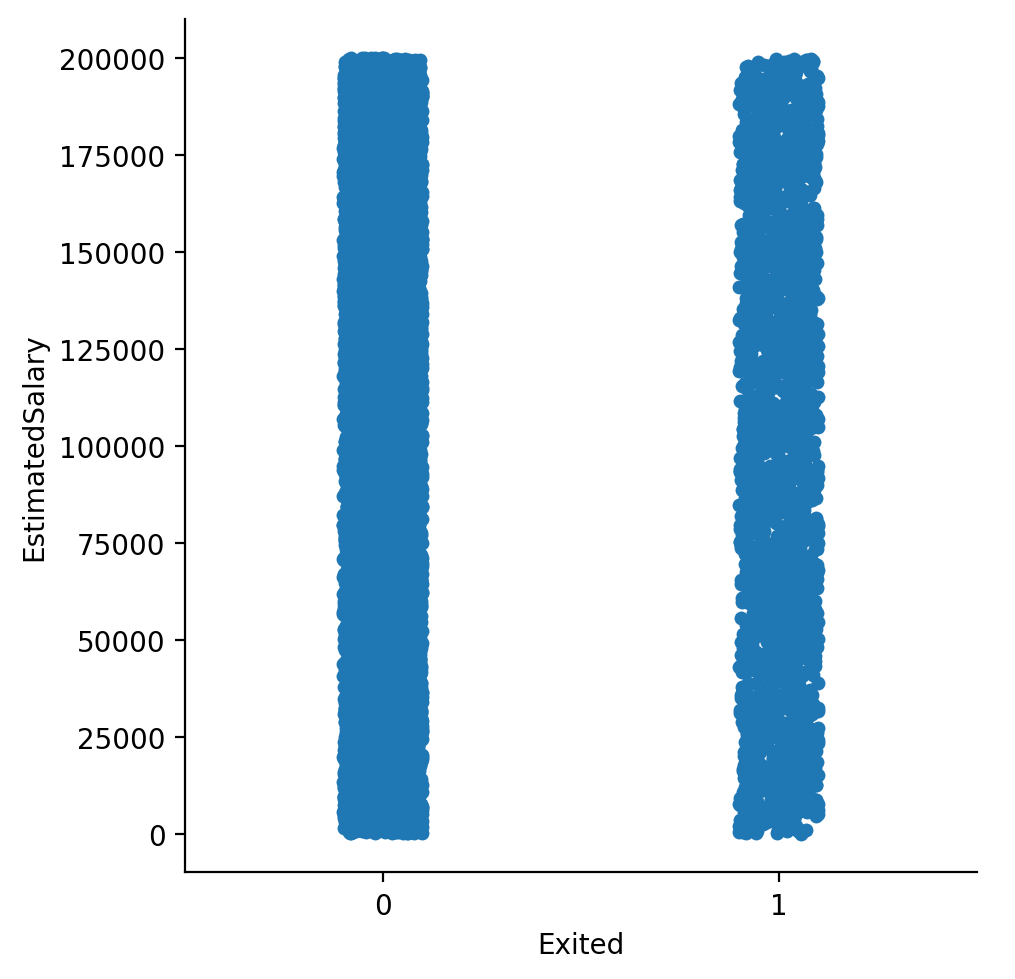

In [118]:
sns.catplot(x="Exited", y="EstimatedSalary", data = df)

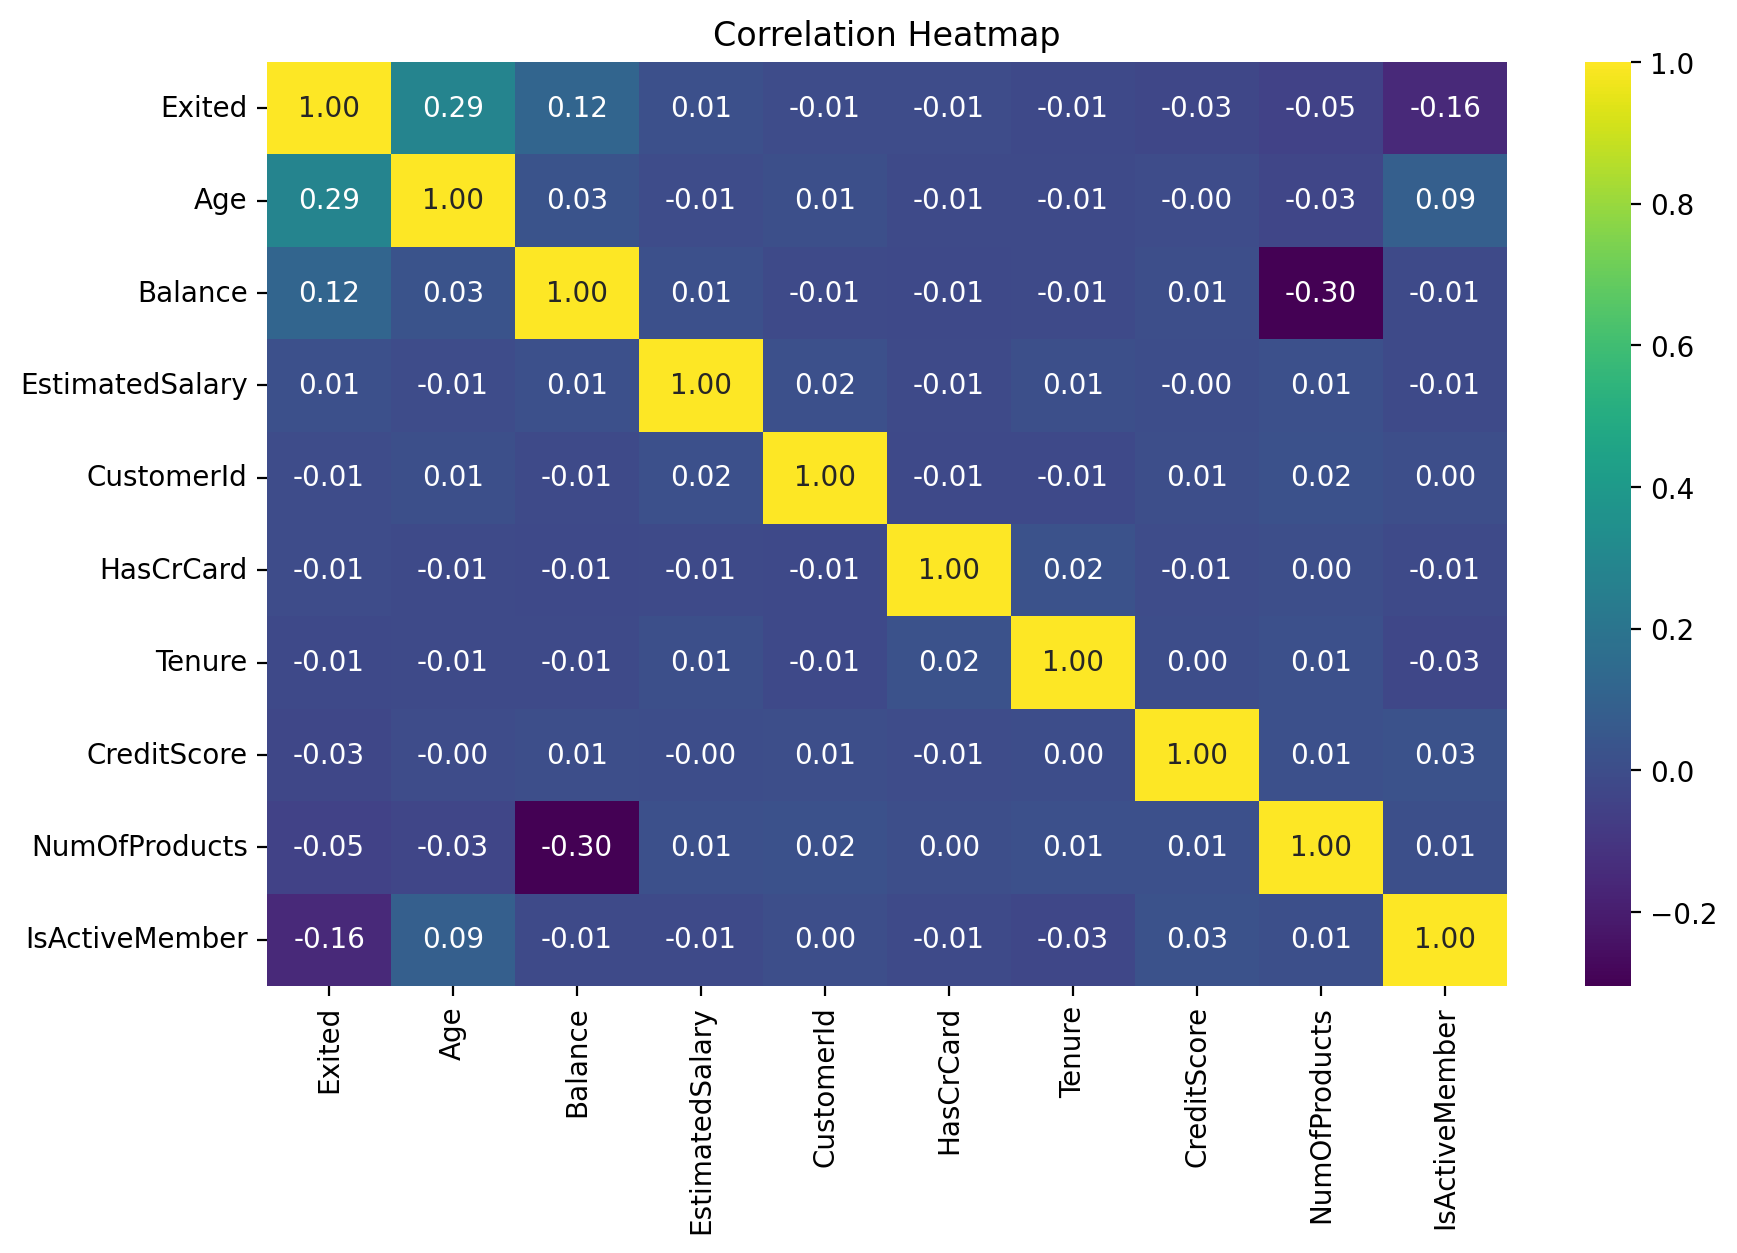

In [121]:
# Select only numeric columns
df_numeric = df.select_dtypes(include=[float, int])

# Get the 'k' variables most correlated with 'Exited'
k = 10
cols = df_numeric.corr().nlargest(k, 'Exited')['Exited'].index

# Get the correlation matrix of these columns
cm = df_numeric[cols].corr()

# Plot the heatmap
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, cmap='viridis', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


In [122]:
df["NewTenure"] = df["Tenure"]/df["Age"]
df["NewCreditsScore"] = pd.qcut(df['CreditScore'], 6, labels = [1, 2, 3, 4, 5, 6])
df["NewAgeScore"] = pd.qcut(df['Age'], 8, labels = [1, 2, 3, 4, 5, 6, 7, 8])
df["NewBalanceScore"] = pd.qcut(df['Balance'].rank(method="first"), 5, labels = [1, 2, 3, 4, 5])
df["NewEstSalaryScore"] = pd.qcut(df['EstimatedSalary'], 10, labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [123]:
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,NewTenure,NewCreditsScore,NewAgeScore,NewBalanceScore,NewEstSalaryScore
RowNumber,,,,,,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,0.047619,3,6,1,6
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0.024390,2,6,3,6
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,0.190476,1,6,5,6
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0.025641,5,5,1,5
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0.046512,6,6,4,4


In [124]:
list = ["Gender", "Geography"]
df = pd.get_dummies(df, columns =list, drop_first = True)

In [125]:
df.head()

,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,NewTenure,NewCreditsScore,NewAgeScore,NewBalanceScore,NewEstSalaryScore,Gender_Male,Geography_Germany,Geography_Spain
RowNumber,,,,,,,,,,,,,,,,,,,
1,15634602,Hargrave,619,42,2,0.00,1,1,1,101348.88,1,0.047619,3,6,1,6,False,False,False
2,15647311,Hill,608,41,1,83807.86,1,0,1,112542.58,0,0.024390,2,6,3,6,False,False,True
3,15619304,Onio,502,42,8,159660.80,3,1,0,113931.57,1,0.190476,1,6,5,6,False,False,False
4,15701354,Boni,699,39,1,0.00,2,0,0,93826.63,0,0.025641,5,5,1,5,False,False,False
5,15737888,Mitchell,850,43,2,125510.82,1,1,1,79084.10,0,0.046512,6,6,4,4,False,False,True


In [126]:
df = df.drop(["CustomerId","Surname"], axis = 1)

In [127]:
def robust_scaler(variable):
    var_median = variable.median()
    quartile1 = variable.quantile(0.25)
    quartile3 = variable.quantile(0.75)
    interquantile_range = quartile3 - quartile1
    if int(interquantile_range) == 0:
        quartile1 = variable.quantile(0.05)
        quartile3 = variable.quantile(0.95)
        interquantile_range = quartile3 - quartile1
        if int(interquantile_range) == 0:
            quartile1 = variable.quantile(0.01)
            quartile3 = variable.quantile(0.99)
            interquantile_range = quartile3 - quartile1
            z = (variable - var_median) / interquantile_range
            return round(z, 3)

        z = (variable - var_median) / interquantile_range
        return round(z, 3)
    else:
        z = (variable - var_median) / interquantile_range
    return round(z, 3)

In [128]:
new_cols_ohe = ["Gender_Male","Geography_Germany","Geography_Spain"]
like_num = [col for col in df.columns if df[col].dtypes != 'O' and len(df[col].value_counts()) <= 10]
cols_need_scale = [col for col in df.columns if col not in new_cols_ohe
                   and col not in "Exited"
                   and col not in like_num]

for col in cols_need_scale:
    df[col] = robust_scaler(df[col])

In [129]:
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,NewTenure,NewCreditsScore,NewAgeScore,NewBalanceScore,NewEstSalaryScore,Gender_Male,Geography_Germany,Geography_Spain
RowNumber,,,,,,,,,,,,,,,,,
1,-0.246,0.417,-0.75,-0.761,1,1,1,0.012,1,-0.217,3,6,1,6,False,False,False
2,-0.328,0.333,-1.00,-0.105,1,0,1,0.126,0,-0.279,2,6,3,6,False,False,True
3,-1.119,0.417,0.75,0.489,3,1,0,0.140,1,0.164,1,6,5,6,False,False,False
4,0.351,0.167,-1.00,-0.761,2,0,0,-0.065,0,-0.276,5,5,1,5,False,False,False
5,1.478,0.500,-0.75,0.222,1,1,1,-0.215,0,-0.220,6,6,4,4,False,False,True


In [131]:

# Assuming df is the DataFrame with the relevant data
X = df.drop("Exited", axis=1)
y = df["Exited"]

# Train-Test Separation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=12345)

# Models for Classification
models = [
    ('LR', LogisticRegression(random_state=123456)),
    ('KNN', KNeighborsClassifier()),
    ('CART', DecisionTreeClassifier(random_state=123456)),
    ('RF', RandomForestClassifier(random_state=123456)),
    ('SVR', SVC(gamma='auto', random_state=123456)),
    ('GB', GradientBoostingClassifier(random_state=12345)),
    ("LightGBM", LGBMClassifier(random_state=123456))
]

results = []
names = []
for name, model in models:
    # Set shuffle=True to use random_state effectively
    kfold = KFold(n_splits=10, shuffle=True, random_state=123456)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold)  # Use X_train and y_train
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)


LR: 0.827125 (0.018892)
KNN: 0.821125 (0.017522)
CART: 0.790000 (0.015114)
RF: 0.861750 (0.013419)
SVR: 0.844375 (0.016204)
GB: 0.866375 (0.011422)
[LightGBM] [Info] Number of positive: 1469, number of negative: 5731
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1138
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.204028 -> initscore=-1.361308
[LightGBM] [Info] Start training from score -1.361308
[LightGBM] [Info] Number of positive: 1449, number of negative: 5751
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000417 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[L

In [132]:
model_GB = GradientBoostingClassifier(random_state=12345)
model_GB.fit(X_train, y_train)
y_pred = model_GB.predict(X_test)
conf_mat = confusion_matrix(y_pred,y_test)
conf_mat

array([[1520,  230],
       [  53,  197]])

In [133]:
print("True Positive : ", conf_mat[1, 1])
print("True Negative : ", conf_mat[0, 0])
print("False Positive: ", conf_mat[0, 1])
print("False Negative: ", conf_mat[1, 0])

True Positive :  197
True Negative :  1520
False Positive:  230
False Negative:  53


In [134]:
print(classification_report(model_GB.predict(X_test),y_test))

              precision    recall  f1-score   support

           0       0.97      0.87      0.91      1750
           1       0.46      0.79      0.58       250

    accuracy                           0.86      2000
   macro avg       0.71      0.83      0.75      2000
weighted avg       0.90      0.86      0.87      2000



In [135]:
def generate_auc_roc_curve(clf, X_test):
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="AUC ROC Curve with Area Under the curve ="+str(auc))
    plt.legend(loc=4)
    plt.show()
    pass

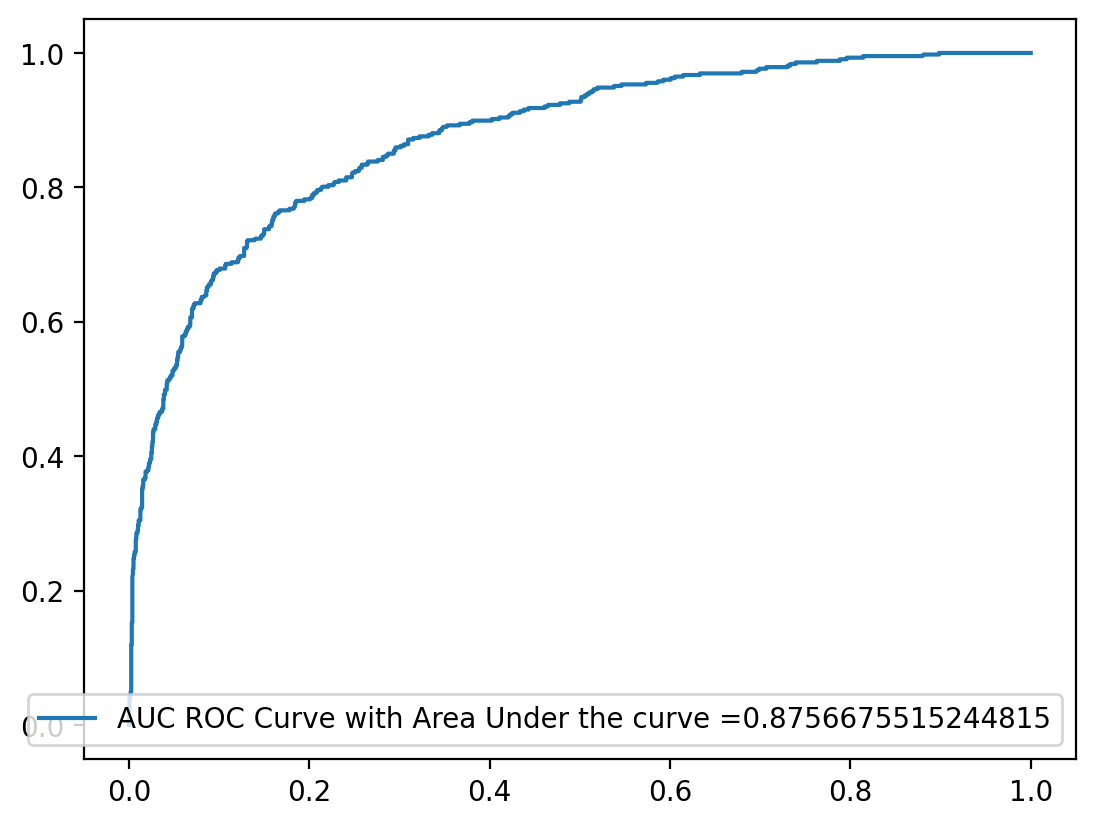

In [136]:
generate_auc_roc_curve(model_GB, X_test)

In [137]:
# LightGBM:
lgb_model = LGBMClassifier()
# Model Tuning
lgbm_params = {'colsample_bytree': 0.5,
 'learning_rate': 0.01,
 'max_depth': 6,
 'n_estimators': 500}

lgbm_tuned = LGBMClassifier(**lgbm_params).fit(X, y)

[LightGBM] [Info] Number of positive: 2037, number of negative: 7963
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1137
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203700 -> initscore=-1.363328
[LightGBM] [Info] Start training from score -1.363328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [138]:
#Let's choose the highest 4 models
# GBM
gbm_model = GradientBoostingClassifier()
# Model Tuning
gbm_params = {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1}
gbm_tuned = GradientBoostingClassifier(**gbm_params).fit(X,y)

In [142]:
import lightgbm as lgb
lgbm_tuned = lgb.LGBMClassifier(random_state=123456)
gbm_tuned = GradientBoostingClassifier(random_state=123456)

# Models for evaluation
models = [("LightGBM", lgbm_tuned), ("GB", gbm_tuned)]

results = []
names = []
for name, model in models:
    # Set shuffle=True to allow random_state to have an effect
    kfold = KFold(n_splits=10, shuffle=True, random_state=123456)
    # Perform cross-validation with the given model
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring="accuracy")

    results.append(cv_results)
    names.append(name)
    # Print mean and std of accuracy for each model
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

[LightGBM] [Info] Number of positive: 1832, number of negative: 7168
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1139
[LightGBM] [Info] Number of data points in the train set: 9000, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203556 -> initscore=-1.364218
[LightGBM] [Info] Start training from score -1.364218
[LightGBM] [Info] Number of positive: 1827, number of negative: 7173
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1138
[LightGBM] [Info] Number of data points in the train set: 9000, number of used features: 16
[LightGBM] [Info] [binar

[LightGBM] [Info] Number of positive: 1610, number of negative: 6390
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1138
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201250 -> initscore=-1.378500
[LightGBM] [Info] Start training from score -1.378500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

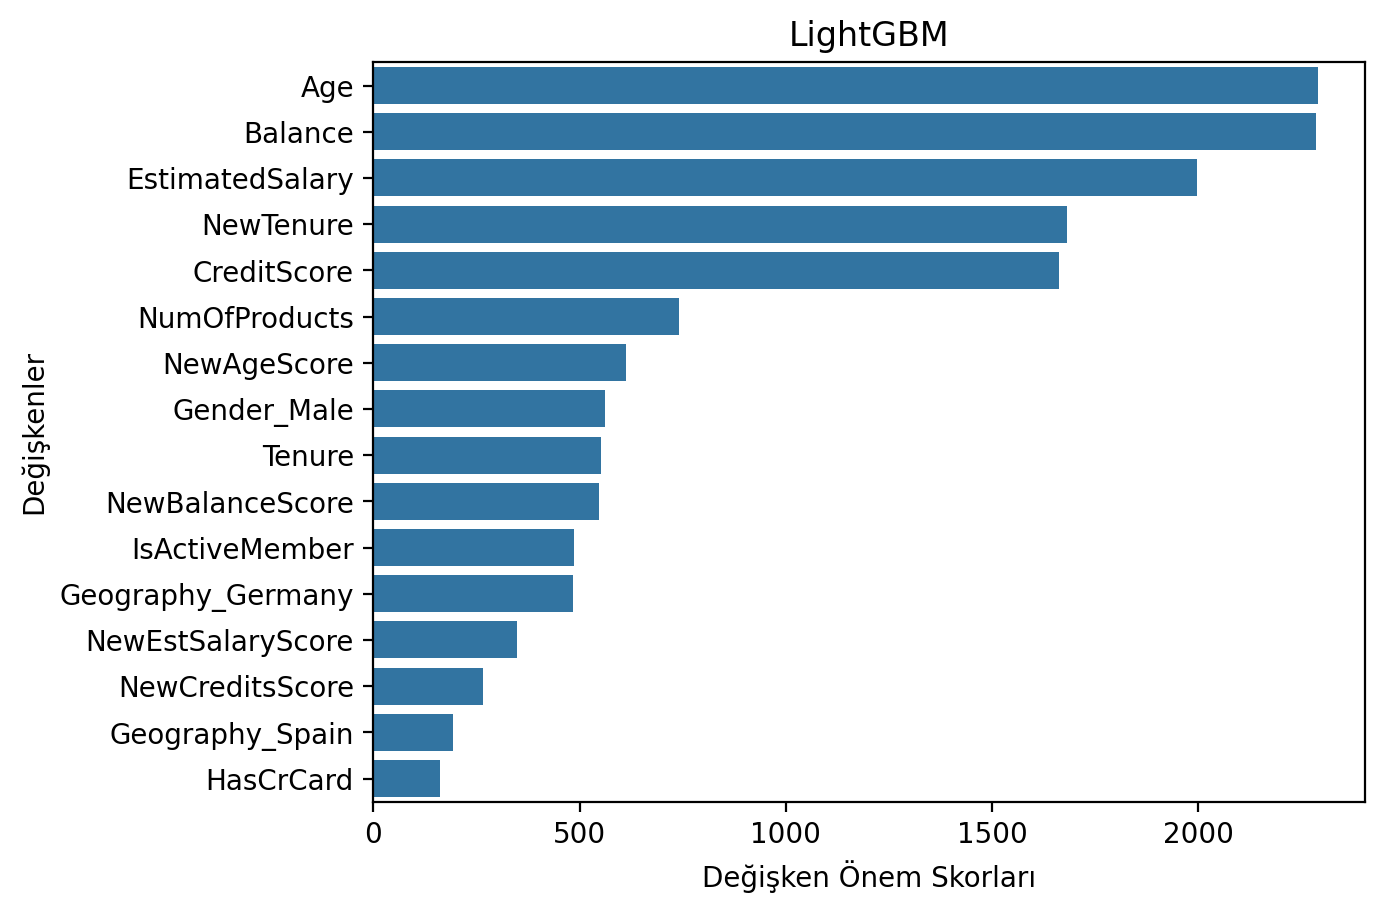

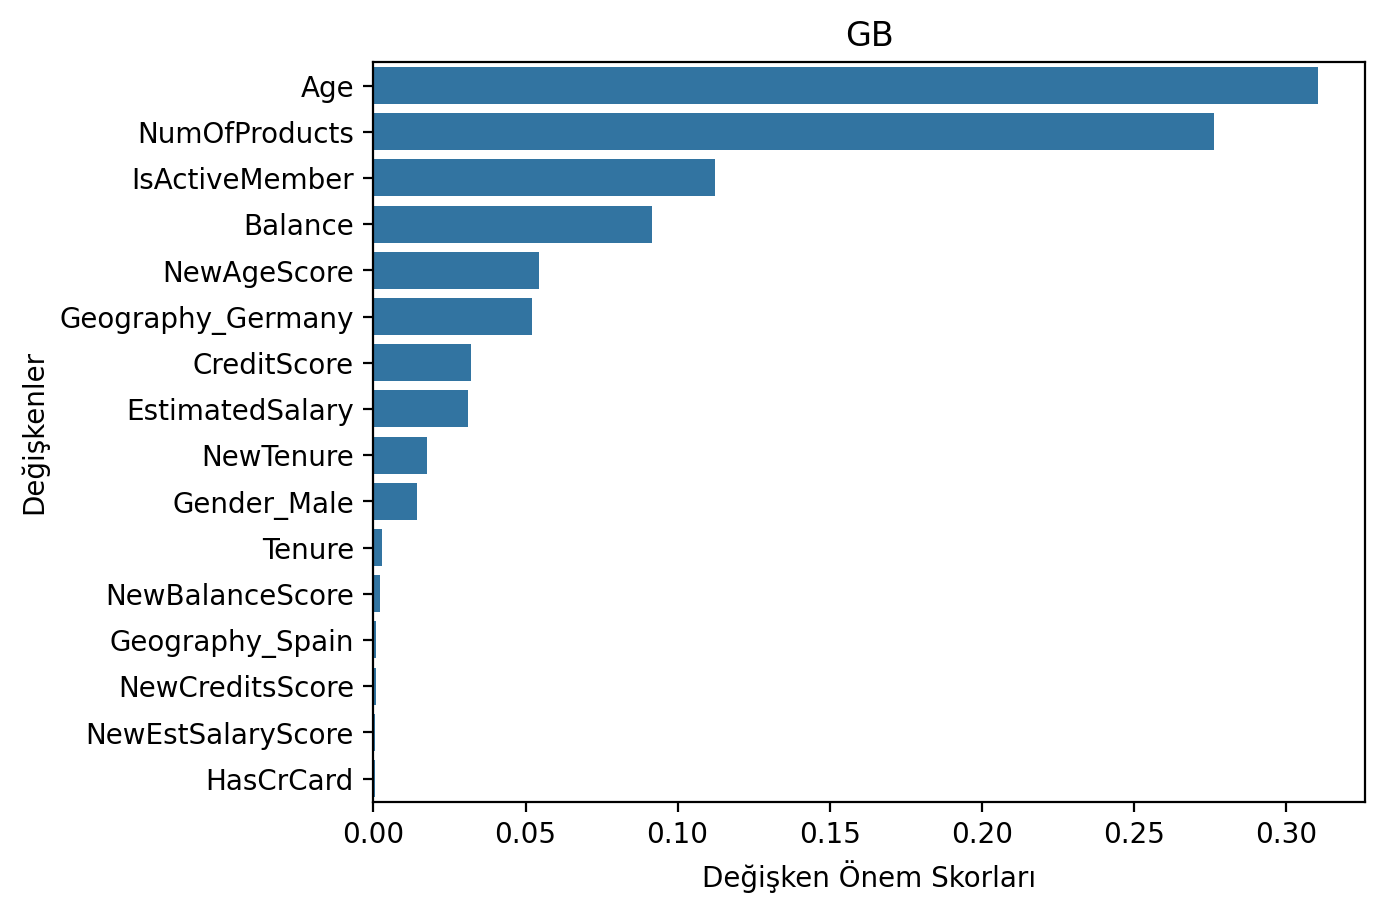

In [141]:
for name, model in models:
        base = model.fit(X_train,y_train)
        y_pred = base.predict(X_test)
        acc_score = accuracy_score(y_test, y_pred)
        feature_imp = pd.Series(base.feature_importances_,
                        index=X.columns).sort_values(ascending=False)

        sns.barplot(x=feature_imp, y=feature_imp.index)
        plt.xlabel('Değişken Önem Skorları')
        plt.ylabel('Değişkenler')
        plt.title(name)
        plt.show()